# Apprentissage semi-supervisé avec label propagation

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# Génération d'un dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=1)
# séparation des données en données d'apprenissage et données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)
# séparation des données d'apprentissage en données étiquetées et données non étiquetées
X_train_lab, X_train_unlab, y_train_lab, y_train_unlab = train_test_split(X_train, y_train, test_size=0.50,
random_state=1, stratify=y_train)
# les dimmensions des données étiquetées et non étiquetées
print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
print('Unlabeled Train Set:', X_train_unlab.shape, y_train_unlab.shape)
# les dimensions des données test
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (250, 2) (250,)
Unlabeled Train Set: (250, 2) (250,)
Test Set: (500, 2) (500,)


# on entraine d'abord un modèle avec les données étiquetées uniquement

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# définition de modèle d'apprentissage supervisé
model = LogisticRegression()
# Entrainement du modèle sur les données étiquetées
model.fit(X_train_lab, y_train_lab)
# Prédiction sur l'ensemble des données test
ypred1 = model.predict(X_test)
# Calcul du score
score = accuracy_score(y_test, ypred1)
# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 84.800


# On étiquette les données non étiquetées avec label propagation

In [7]:
# evaluation du modèle label propagation() sur les données d'apprentissage  sémi supervisé
from numpy import concatenate
from sklearn.semi_supervised import LabelPropagation
# creation des données d'entraiment pour le modèle
X_train_mixed = concatenate((X_train_lab, X_train_unlab))
# creation de "no label" pour  les données non étiquetées
nolabel = [-1 for _ in range(len(y_train_unlab))]
# recombinaison des classes des données d'entrainement 
y_train_mixed = concatenate((y_train_lab, nolabel))
# definition du modèle
model = LabelPropagation()
# entrainement du modèle
model.fit(X_train_mixed, y_train_mixed)
# prediction du modèle sur l'ensemble des données test
yhat = model.predict(X_test)
# calcul du score du modèle
score = accuracy_score(y_test, yhat)
# affichage du  score
print('Accuracy: %.3f' % (score*100))

Accuracy: 85.600


# on réentraine le modèle de regression linéaire

In [8]:
# recuperation des étiquettes de toute les données
tran_labels = model.transduction_
# definition d'un nouveau modèle de regression logistique
model2 = LogisticRegression()
# entrainement du modèle e
model2.fit(X_train_mixed, tran_labels)
# prediction sur les données  test
yhat = model2.predict(X_test)
# calcul du score
score = accuracy_score(y_test, yhat)
# affichage du score
print('Accuracy: %.3f' % (score*100))

Accuracy: 86.200


# EM

# Librairies

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import warnings
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter('ignore', UserWarning)


C:\Users\JFrancois\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Simulation

In [22]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
    return data

In [24]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
[1, 2],
[10, 2]])
init_covariances = np.array([
[[1, 0.], [0, 1]],
[[4, 0], [0, 4]]])
init_weights = [1 / 2, 1 / 2]
# generate data
np.random.seed(4)
X_sampled = generate_data(1000, init_means, init_covariances, init_weights)


In [25]:
X_sampled

array([[10.90072301,  2.09000335],
       [ 8.00818214,  3.38719702],
       [12.90325121,  1.32237604],
       ...,
       [ 0.34403402,  0.24658133],
       [ 8.91760206,  3.55407782],
       [12.83225465,  4.43136377]])

### Afficher l'échantillon

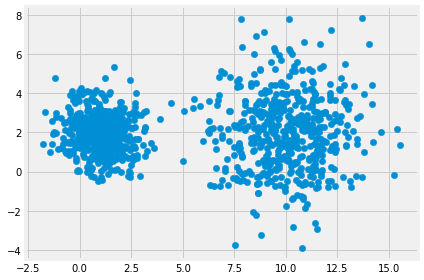

In [26]:
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], s=40, cmap='viridis');
plt.tight_layout()


### Afficher le graphique de contour de la densité bidimensionnelle

<AxesSubplot:>

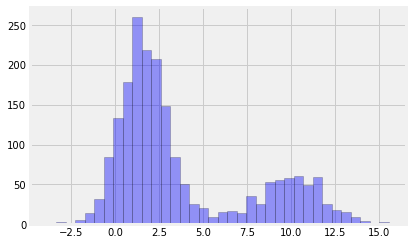

In [30]:
# seaborn histogram
sns.distplot(X_sampled, hist=True, kde=False,
bins=int(180/5), color = 'blue',
hist_kws={'edgecolor':'black'})


C:\Users\JFrancois\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

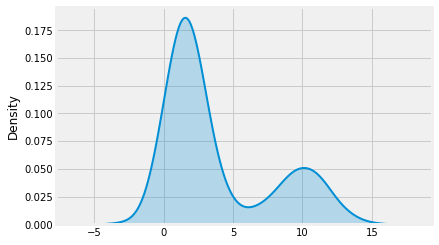

In [31]:
# density plot
sns.distplot(X_sampled, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2})


### fonction pour éxécuter l'algorithme GMM  de sklearn.mixture

In [33]:
def GMM_sk_results(X,n_clusters):
    gmm = GM(n_components=n_clusters).fit(X)
    labels = gmm.predict(X)
    print("Converged =",gmm.converged_)
    print("****"*12)
    print("max_iter =",gmm.max_iter)
    print("****"*12)
    print("weights pi vector =",gmm.weights_)
    print("****"*12)
    print("means vector =",gmm.means_)
    print("****"*12)
    print("covariances vector =",gmm.covariances_)
    print("****"*12)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
    #return labels

### Estimation des paramètres et répartition des données simulées X en deux classes à l'aide de GMM sklearn

Converged = True
************************************************
max_iter = 100
************************************************
weights pi vector = [0.50998284 0.49001716]
************************************************
means vector = [[10.00891362  2.03429885]
 [ 1.01386795  1.95375009]]
************************************************
covariances vector = [[[ 3.27664234  0.05501079]
  [ 0.05501079  3.75058771]]

 [[ 0.94082329 -0.07953763]
  [-0.07953763  0.99494591]]]
************************************************


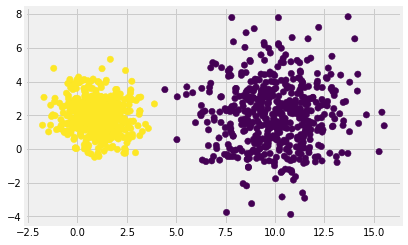

In [34]:
GMM_sk_results(X_sampled,2)


### Partition des données simulées X en deux classes à l'aide de kmeans

In [44]:
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
def kmeans_results(X,n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    plot_kmeans(kmeans, X, n_clusters=n_clusters)
    #return kmeans.fit_predict(X)

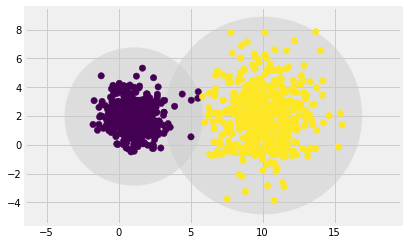

In [45]:
kmeans_results(X_sampled,2)


In [56]:
def compare(X,n_clusters):
    kmeans_clust= KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
    gmm = GM(n_components=n_clusters).fit(X)
    gmm_clust=gmm.predict(X)
    print("Accuracy inter models Kmeans & GMM =",(kmeans_clust==gmm_clust).sum()/len(kmeans_clust)*100,"%")


In [57]:
compare(X_sampled,2)


Accuracy inter models Kmeans & GMM = 0.5 %


Précision entre les modèles Kmeans et GMM = 99.5 %
Nous concluons que le Kmean et le GMM capturent parfaitement la densité des clusters avec une erreur de
5% entre les modèles